In [16]:
# Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

In [96]:
# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

# Download stock price data from Yahoo Finance using ticker 'COIN'
ticker = 'COIN'
data_coin = yf.download(tickers=ticker, start=start_date, end=end_date)
df_coin = pd.DataFrame(data_coin)
df_coin.reset_index(inplace=True)
df_coin.set_index('Date', inplace=True)

# Download gold prices and US Dollar index data from Yahoo Finance
tick_gold = 'GC=F'
tick_usindex = 'DX-Y.NYB'
data_gold = yf.download(tickers=tick_gold, start=start_date, end=end_date)
data_usindex = yf.download(tickers=tick_usindex, start=start_date, end=end_date)

# Convert downloaded data into dataframes
df_gold = pd.DataFrame(data_gold)
df_usindex = pd.DataFrame(data_usindex)

# Extract the adjusted close prices from gold and US Dollar index dataframes
df_coin['Gold_Adj_Close'] = df_gold['Adj Close']
df_coin['USIndex_Adj_Close'] = df_usindex['Adj Close']

# Forward fill missing values to align the data properly
df_coin = df_coin.ffill()

df_coin

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close
Date,,,,,,,,
2021-04-14,381.000000,429.540009,310.000000,328.279999,328.279999,81065700,1734.900024,91.690002
2021-04-15,348.899994,349.200012,317.269989,322.750000,322.750000,39777900,1765.400024,91.669998
2021-04-16,327.500000,345.989990,321.029999,342.000000,342.000000,22654500,1779.000000,91.559998
2021-04-19,337.260010,341.010010,326.790009,333.000000,333.000000,11405600,1769.400024,91.070000
2021-04-20,333.429993,334.829987,312.019989,320.820007,320.820007,18082300,1777.300049,91.239998
...,...,...,...,...,...,...,...,...
2024-06-17,239.869995,248.639999,234.229996,245.100006,245.100006,6662900,2312.399902,105.320000
2024-06-18,238.250000,242.800003,234.600006,235.949997,235.949997,6198900,2330.399902,105.260002
2024-06-20,237.360001,240.490005,228.440002,235.029999,235.029999,6888900,2353.800049,105.589996


In [3]:
# Check for null values
df_coin.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Gold_Adj_Close       0
USIndex_Adj_Close    0
dtype: int64

In [4]:
# Stats for data
df_coin.describe()

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close
count,804.000000,804.000000,804.000000,804.000000,804.000000,8.040000e+02,804.000000,804.000000
mean,147.744490,152.466125,143.008843,147.557861,147.557861,1.113577e+07,1904.975494,101.392326
std,88.833601,90.773706,86.478670,88.402076,88.402076,8.512028e+06,163.642132,5.582904
min,32.580002,33.480000,31.549999,32.529999,32.529999,1.574700e+06,1623.300049,89.639999
25%,66.517500,69.557497,63.395001,66.727499,66.727499,5.405250e+06,1792.375031,96.290001
50%,124.025002,128.035004,118.660000,123.125000,123.125000,9.343750e+06,1871.349976,103.135002
75%,231.744999,238.695000,226.730000,232.217506,232.217506,1.407348e+07,1978.174988,105.012501
max,381.000000,429.540009,345.559998,357.390015,357.390015,8.106570e+07,2433.899902,114.110001


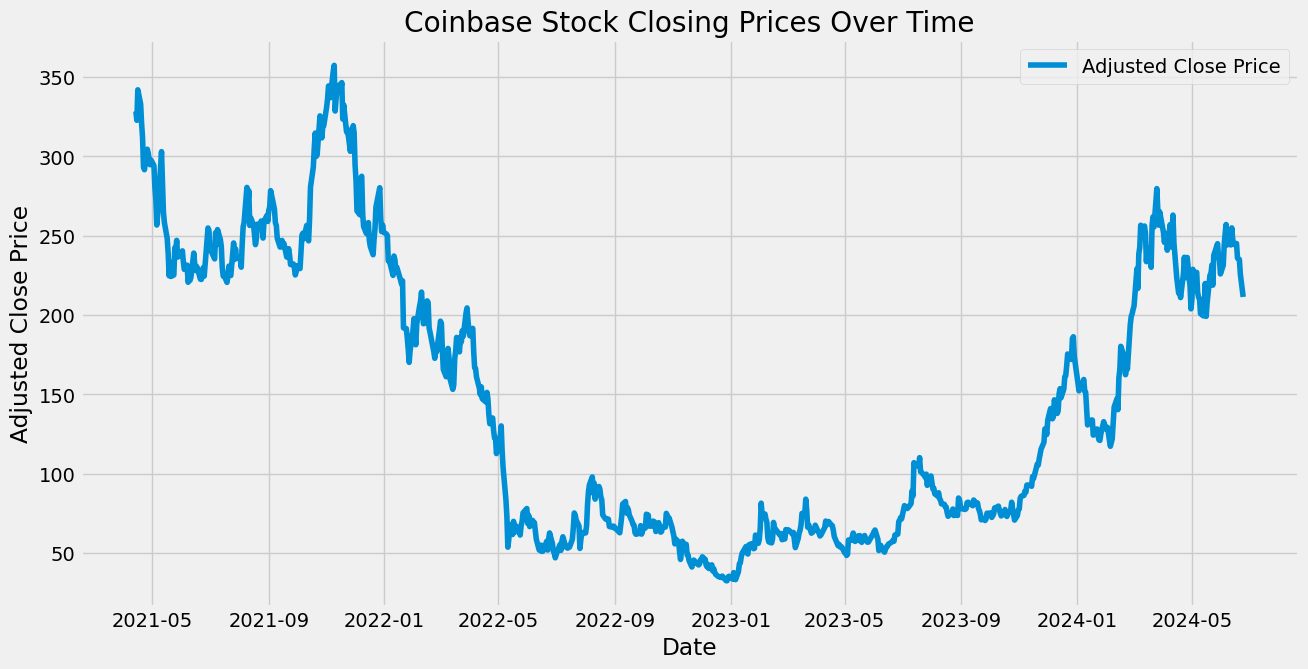

In [5]:
# Plotting the Adjusted Close price to show the trend
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14, 7))
plt.plot(df_coin.index, df_coin['Adj Close'], label='Adjusted Close Price')
plt.title('Coinbase Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Calculate differences between open, high, low, and adjusted close prices for the stock data
df_coin['Open_Close_Diff'] = df_coin['Open'] - df_coin['Adj Close']
df_coin['High_Low_Diff'] = df_coin['High'] - df_coin['Low']

# Calculate percentage returns and log percentage returns
df_coin['Pct_Returns'] = df_coin['Adj Close'].pct_change()
df_coin['Log_Pct_Returns'] = np.log(1 + df_coin['Pct_Returns'])
df_coin.dropna(inplace=True)
df_coin

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,Pct_Returns,Log_Pct_Returns
Date,,,,,,,,,,,,
2021-04-15,348.899994,349.200012,317.269989,322.750000,322.750000,39777900,1765.400024,91.669998,26.149994,31.930023,-0.016845,-0.016989
2021-04-16,327.500000,345.989990,321.029999,342.000000,342.000000,22654500,1779.000000,91.559998,-14.500000,24.959991,0.059644,0.057933
2021-04-19,337.260010,341.010010,326.790009,333.000000,333.000000,11405600,1769.400024,91.070000,4.260010,14.220001,-0.026316,-0.026668
2021-04-20,333.429993,334.829987,312.019989,320.820007,320.820007,18082300,1777.300049,91.239998,12.609985,22.809998,-0.036577,-0.037262
2021-04-21,312.519989,327.470001,302.100006,311.920013,311.920013,10103900,1792.300049,91.160004,0.599976,25.369995,-0.027741,-0.028133
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17,239.869995,248.639999,234.229996,245.100006,245.100006,6662900,2312.399902,105.320000,-5.230011,14.410004,0.002454,0.002451
2024-06-18,238.250000,242.800003,234.600006,235.949997,235.949997,6198900,2330.399902,105.260002,2.300003,8.199997,-0.037332,-0.038046
2024-06-20,237.360001,240.490005,228.440002,235.029999,235.029999,6888900,2353.800049,105.589996,2.330002,12.050003,-0.003899,-0.003907


In [7]:
# List of columns to shift
columns_to_shift = [
    'Open', 'High', 'Adj Close', 'Low', 'Volume',
     'Open_Close_Diff', 'High_Low_Diff', 
     'Gold_Adj_Close', 'USIndex_Adj_Close'
]

# Number of lagged versions to create
num_lags = 3  

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):
        df_coin[f'{column}_{lag}'] = df_coin[column].shift(lag)

df_coin['Pct_Returns_1'] = df_coin['Pct_Returns'].shift(1)
df_coin['Log_Pct_Returns_1'] = df_coin['Log_Pct_Returns'].shift(1)

df_coin.dropna(inplace=True)
df_coin

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,...,High_Low_Diff_2,High_Low_Diff_3,Gold_Adj_Close_1,Gold_Adj_Close_2,Gold_Adj_Close_3,USIndex_Adj_Close_1,USIndex_Adj_Close_2,USIndex_Adj_Close_3,Pct_Returns_1,Log_Pct_Returns_1
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-20,333.429993,334.829987,312.019989,320.820007,320.820007,18082300,1777.300049,91.239998,12.609985,22.809998,...,24.959991,31.930023,1769.400024,1779.000000,1765.400024,91.070000,91.559998,91.669998,-0.026316,-0.026668
2021-04-21,312.519989,327.470001,302.100006,311.920013,311.920013,10103900,1792.300049,91.160004,0.599976,25.369995,...,14.220001,24.959991,1777.300049,1769.400024,1779.000000,91.239998,91.070000,91.559998,-0.036577,-0.037262
2021-04-22,305.760010,313.500000,287.200012,293.450012,293.450012,14991900,1781.199951,91.330002,12.309998,26.299988,...,22.809998,14.220001,1792.300049,1777.300049,1769.400024,91.160004,91.239998,91.070000,-0.027741,-0.028133
2021-04-23,282.750000,303.000000,282.070007,291.600006,291.600006,9853800,1777.000000,90.860001,-8.850006,20.929993,...,25.369995,22.809998,1781.199951,1792.300049,1777.300049,91.330002,91.160004,91.239998,-0.059214,-0.061039
2021-04-26,304.290009,306.100006,296.899994,304.540009,304.540009,6330200,1779.199951,90.809998,-0.250000,9.200012,...,26.299988,25.369995,1777.000000,1781.199951,1792.300049,90.860001,91.330002,91.160004,-0.006304,-0.006324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17,239.869995,248.639999,234.229996,245.100006,245.100006,6662900,2312.399902,105.320000,-5.230011,14.410004,...,13.870010,12.680008,2331.399902,2300.199951,2336.000000,105.550003,105.199997,104.650002,-0.012680,-0.012761
2024-06-18,238.250000,242.800003,234.600006,235.949997,235.949997,6198900,2330.399902,105.260002,2.300003,8.199997,...,13.190002,13.870010,2312.399902,2331.399902,2300.199951,105.320000,105.550003,105.199997,0.002454,0.002451
2024-06-20,237.360001,240.490005,228.440002,235.029999,235.029999,6888900,2353.800049,105.589996,2.330002,12.050003,...,14.410004,13.190002,2330.399902,2312.399902,2331.399902,105.260002,105.320000,105.550003,-0.037332,-0.038046


##### Technical Indicators

In [8]:
# Moving Averages

# Simple Moving Averages
df_coin['SMA_5'] = df_coin['Adj Close'].rolling(window=5).mean()
df_coin['SMA_10'] = df_coin['Adj Close'].rolling(window=10).mean()
df_coin['SMA_20'] = df_coin['Adj Close'].rolling(window=20).mean()
df_coin['SMA_50'] = df_coin['Adj Close'].rolling(window=50).mean()

# Exponential Moving Averages
df_coin['EMA_50'] = df_coin['Adj Close'].ewm(span=50, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
delta = df_coin['Adj Close'].diff()
gain = (delta.where(delta>0, 0)).rolling(window=window_length).mean()
loss = (delta.where(delta<0, 0)).rolling(window=window_length).mean()
rs = gain/loss
df_coin['RSI'] = 100 - (100/(1+rs))

# Moving Average Convergence Divergence (MACD)
df_coin['MACD'] = df_coin['Adj Close'].ewm(span=12, adjust=False).mean() - df_coin['Adj Close'].ewm(span=26, adjust=False).mean()
df_coin['MACD_Signal'] = df_coin['MACD'].ewm(span=9, adjust=False).mean()
df_coin['MACD_Hist'] = df_coin['MACD'] - df_coin['MACD_Signal']

# Bollinger Bands
df_coin['BB_Upper'] = df_coin['SMA_20'] + 2*df_coin['Adj Close'].rolling(window=20).std()
df_coin['BB_Lower'] = df_coin['SMA_20'] - 2*df_coin['Adj Close'].rolling(window=20).std()

# Stochastic Oscillator
df_coin['14-high'] = df_coin['High'].rolling(14).max()
df_coin['14-low'] = df_coin['Low'].rolling(14).min()
df_coin['%K'] = (df_coin['Adj Close'] - df_coin['14-low']) * 100 / (df_coin['14-high'] - df_coin['14-low'])
df_coin['%D'] = df_coin['%K'].rolling(3).mean()

# Average True Range (ATR)
df_coin['H-L'] = df_coin['High'] - df_coin['Low']
df_coin['H-PC'] = np.abs(df_coin['High'] - df_coin['Adj Close'].shift(1))
df_coin['L-PC'] = np.abs(df_coin['Low'] - df_coin['Adj Close'].shift(1))
df_coin['TR'] = df_coin[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_coin['ATR'] = df_coin['TR'].rolling(14).mean()

df_coin

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,...,BB_Lower,14-high,14-low,%K,%D,H-L,H-PC,L-PC,TR,ATR
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-20,333.429993,334.829987,312.019989,320.820007,320.820007,18082300,1777.300049,91.239998,12.609985,22.809998,...,NaN,NaN,NaN,NaN,NaN,22.809998,NaN,NaN,22.809998,NaN
2021-04-21,312.519989,327.470001,302.100006,311.920013,311.920013,10103900,1792.300049,91.160004,0.599976,25.369995,...,NaN,NaN,NaN,NaN,NaN,25.369995,6.649994,18.720001,25.369995,NaN
2021-04-22,305.760010,313.500000,287.200012,293.450012,293.450012,14991900,1781.199951,91.330002,12.309998,26.299988,...,NaN,NaN,NaN,NaN,NaN,26.299988,1.579987,24.720001,26.299988,NaN
2021-04-23,282.750000,303.000000,282.070007,291.600006,291.600006,9853800,1777.000000,90.860001,-8.850006,20.929993,...,NaN,NaN,NaN,NaN,NaN,20.929993,9.549988,11.380005,20.929993,NaN
2021-04-26,304.290009,306.100006,296.899994,304.540009,304.540009,6330200,1779.199951,90.809998,-0.250000,9.200012,...,NaN,NaN,NaN,NaN,NaN,9.200012,14.500000,5.299988,14.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17,239.869995,248.639999,234.229996,245.100006,245.100006,6662900,2312.399902,105.320000,-5.230011,14.410004,...,218.364226,263.799988,219.169998,58.099964,59.548905,14.410004,4.139999,10.270004,14.410004,15.414286
2024-06-18,238.250000,242.800003,234.600006,235.949997,235.949997,6198900,2330.399902,105.260002,2.300003,8.199997,...,219.929995,263.799988,219.169998,37.598034,50.817854,8.199997,2.300003,10.500000,10.500000,15.320000
2024-06-20,237.360001,240.490005,228.440002,235.029999,235.029999,6888900,2353.800049,105.589996,2.330002,12.050003,...,221.386009,263.799988,219.169998,35.536644,43.744881,12.050003,4.540009,7.509995,12.050003,15.075000


In [9]:
# List of columns to shift
columns_to_shift = [
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 
    'MACD_Hist', 'BB_Upper', 'BB_Lower', '%K', '%D', 'ATR'
]

# Number of lagged versions to create
num_lags = 2

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):
        df_coin[f'{column}_{lag}'] = df_coin[column].shift(lag)

df_coin.dropna(inplace=True)
df_coin


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,...,BB_Upper_1,BB_Upper_2,BB_Lower_1,BB_Lower_2,%K_1,%K_2,%D_1,%D_2,ATR_1,ATR_2
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,251.089996,255.149994,240.529999,241.440002,241.440002,3611300,1775.900024,92.599998,9.649994,14.619995,...,251.226162,248.297110,211.213839,212.860890,84.418435,87.594281,89.446274,77.139834,9.779282,9.809281
2021-07-02,242.000000,246.800003,238.880005,240.720001,240.720001,2325000,1782.599976,92.230003,1.279999,7.919998,...,252.111320,251.226162,211.106681,211.213839,60.877341,84.418435,77.630019,89.446274,10.545710,9.779282
2021-07-06,243.000000,243.000000,234.020004,235.410004,235.410004,2212600,1793.500000,92.550003,7.589996,8.979996,...,253.053757,252.111320,211.357244,211.106681,59.448200,60.877341,68.247992,77.630019,9.979996,10.545710
2021-07-07,238.960007,252.990005,232.339996,251.970001,251.970001,4804400,1801.500000,92.639999,-13.009995,20.650009,...,253.296716,253.053757,211.510286,211.357244,48.908306,59.448200,56.411282,68.247992,10.039995,9.979996
2021-07-08,239.000000,246.600006,233.610001,244.289993,244.289993,4350000,1799.599976,92.360001,-5.289993,12.990005,...,255.827026,253.296716,212.110976,211.510286,81.778494,48.908306,63.378333,56.411282,10.914997,10.039995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17,239.869995,248.639999,234.229996,245.100006,245.100006,6662900,2312.399902,105.320000,-5.230011,14.410004,...,263.532409,266.331908,212.293588,204.961088,56.755563,63.791189,67.129235,67.384246,15.533572,15.943571
2024-06-18,238.250000,242.800003,234.600006,235.949997,235.949997,6198900,2330.399902,105.260002,2.300003,8.199997,...,261.211770,263.532409,218.364226,212.293588,58.099964,56.755563,59.548905,67.129235,15.414286,15.533572
2024-06-20,237.360001,240.490005,228.440002,235.029999,235.029999,6888900,2353.800049,105.589996,2.330002,12.050003,...,260.722001,261.211770,219.929995,218.364226,37.598034,58.099964,50.817854,59.548905,15.320000,15.414286


#### Economic Indicators

In [10]:
# Fetch inflation rate data(Daily) from FRED using pandas_datareader
Inflation_df = pdr.get_data_fred('T5YIE', start=start_date, end=end_date)
Inflation_df.ffill()
Inflation_df.dropna(inplace=True)

# Fetch Federal fund rates data(Monthly) from FRED using pandas_datareader
Fedfunds_Mon = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)
Fedfunds_df = Fedfunds_Mon.resample('D').ffill()
Fedfunds_df.dropna(inplace=True)

# Fetch GDP growth data(Quarterly) from FRED using pandas_datareader
Gdp_Data_Quat = pdr.get_data_fred('GDPC1', start=start_date, end=end_date)
Gdp_Data_df = Gdp_Data_Quat.resample('D').ffill()
Gdp_Data_df.dropna(inplace=True)

# Fetch Unemployment rate data(Monthly) from FRED using pandas_datareader
Unemp_Data_Mon = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
Unemp_Data_df = Unemp_Data_Mon.resample('D').ffill()
Unemp_Data_df.dropna(inplace=True)

# Fetch University of Michigan Consumer Sentiment data(Monthly) from FRED using pandas_datareader
UM_Sent_Mon = pdr.get_data_fred('UMCSENT', start=start_date, end=end_date)
UM_Sent_df = UM_Sent_Mon.resample('D').ffill()
UM_Sent_df.dropna(inplace=True)

# Fetch Consumer Price Index data(Monthly) from FRED using pandas_datareader
Core_Cpi_Mon = pdr.get_data_fred('CPILFESL', start=start_date, end=end_date)
Core_Cpi_df = Core_Cpi_Mon.resample('D').ffill()
Core_Cpi_df.dropna(inplace=True)

# Fetch Commodity price data(Monthly) from FRED using pandas_datareader
Commpriceindex_Data_Mon = pdr.get_data_fred('PPIACO', start=start_date, end=end_date)
Commpriceindex_Data_df = Commpriceindex_Data_Mon.resample('D').ffill()
Commpriceindex_Data_df.dropna(inplace=True)

# Fetch M2 money supply from FRED using pandas_datareader
M2_Money_Supply_Mon = pdr.get_data_fred('WM2NS', start=start_date, end=end_date)
M2_Money_Supply_df = M2_Money_Supply_Mon.resample('D').ffill()
M2_Money_Supply_df.dropna(inplace=True)

# Setting 'Date' as index for economic data
Inflation_df.index = pd.to_datetime(Inflation_df.index)
Fedfunds_df.index = pd.to_datetime(Fedfunds_df.index)
Gdp_Data_df.index = pd.to_datetime(Gdp_Data_df.index)
Unemp_Data_df.index = pd.to_datetime(Unemp_Data_df.index)
UM_Sent_df.index = pd.to_datetime(UM_Sent_df.index)
Core_Cpi_Mon.index = pd.to_datetime(Core_Cpi_Mon.index)
Commpriceindex_Data_df.index = pd.to_datetime(Commpriceindex_Data_df.index)
M2_Money_Supply_df.index = pd.to_datetime(M2_Money_Supply_df.index)

# Merge main df with economic dataframes on 'Date'
merged_df = df_coin.join(Inflation_df, 
                    how='left').join(Fedfunds_df, 
                    how='left').join(Gdp_Data_df, 
                    how='left').join(Unemp_Data_df, 
                    how='left').join(UM_Sent_df,
                    how='left').join(Core_Cpi_df,
                    how='left').join(Commpriceindex_Data_df,
                    how='left').join(M2_Money_Supply_df,
                    how='left')
merged_df.dropna(inplace=True)
merged_df


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,...,ATR_1,ATR_2,T5YIE,FEDFUNDS,GDPC1,UNRATE,UMCSENT,CPILFESL,PPIACO,WM2NS
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,251.089996,255.149994,240.529999,241.440002,241.440002,3611300,1775.900024,92.599998,9.649994,14.619995,...,9.779282,9.809281,2.49,0.10,21483.083,5.4,81.2,278.612,231.850,20327.8
2021-07-02,242.000000,246.800003,238.880005,240.720001,240.720001,2325000,1782.599976,92.230003,1.279999,7.919998,...,10.545710,9.779282,2.49,0.10,21483.083,5.4,81.2,278.612,231.850,20327.8
2021-07-06,243.000000,243.000000,234.020004,235.410004,235.410004,2212600,1793.500000,92.550003,7.589996,8.979996,...,9.979996,10.545710,2.48,0.10,21483.083,5.4,81.2,278.612,231.850,20547.0
2021-07-07,238.960007,252.990005,232.339996,251.970001,251.970001,4804400,1801.500000,92.639999,-13.009995,20.650009,...,10.039995,9.979996,2.43,0.10,21483.083,5.4,81.2,278.612,231.850,20547.0
2021-07-08,239.000000,246.600006,233.610001,244.289993,244.289993,4350000,1799.599976,92.360001,-5.289993,12.990005,...,10.914997,10.039995,2.38,0.10,21483.083,5.4,81.2,278.612,231.850,20547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,169.770004,178.699997,167.899994,175.479996,175.479996,15788000,2057.100098,101.699997,-5.709991,10.800003,...,9.246428,9.339286,2.16,5.33,22679.255,3.7,69.7,313.209,249.866,20875.3
2023-12-26,174.800003,178.119995,169.050003,172.050003,172.050003,12544800,2058.199951,101.470001,2.750000,9.069992,...,9.122142,9.246428,2.17,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5
2023-12-27,176.320007,186.970001,175.500000,185.240005,185.240005,15569900,2081.899902,100.989998,-8.919998,11.470001,...,9.149998,9.122142,2.12,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5


Training MSE: 0.0006
Training MSE Std Dev: 0.0004
Test MSE: 0.0011
Test MSE Std Dev: 0.0012
Training RMSE: 0.0217
Training RMSE Std Dev: 0.0118
Test RMSE: 0.0293
Test RMSE Std Dev: 0.0169
Training MAE: 0.0151
Training MAE Std Dev: 0.0084
Test MAE: 0.0219
Test MAE Std Dev: 0.0129
Training R2: 0.8275
Training R2 Std Dev: 0.1054
Test R2: 0.7555
Test R2 Std Dev: 0.1459


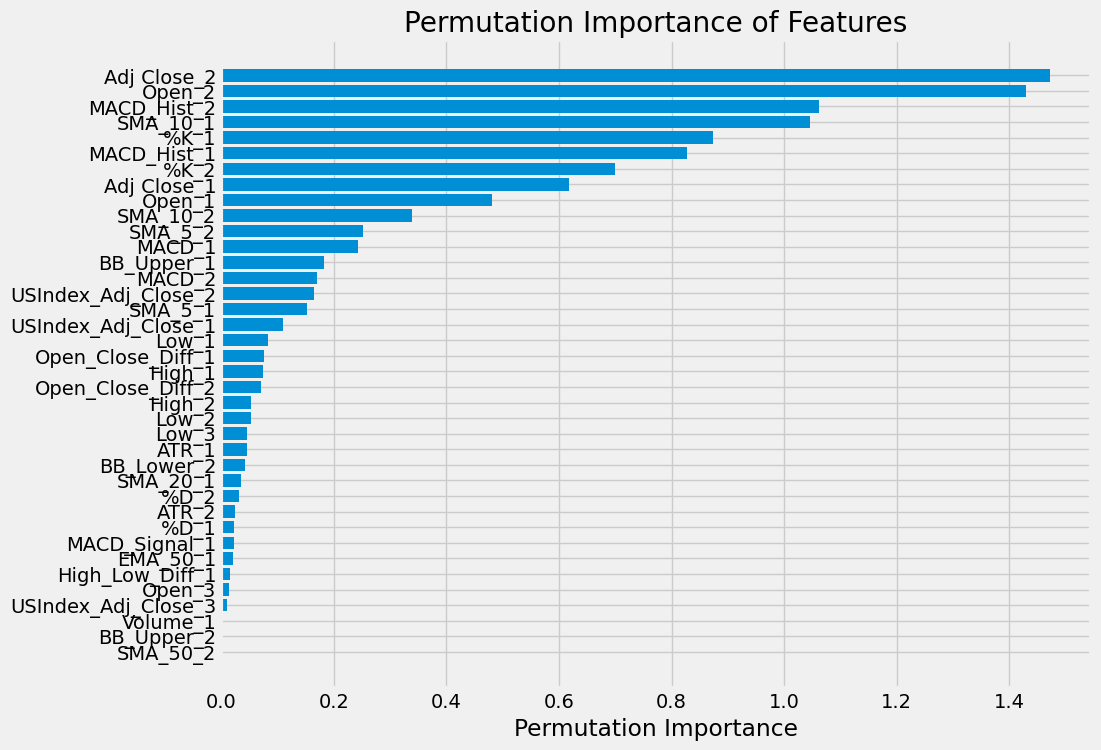

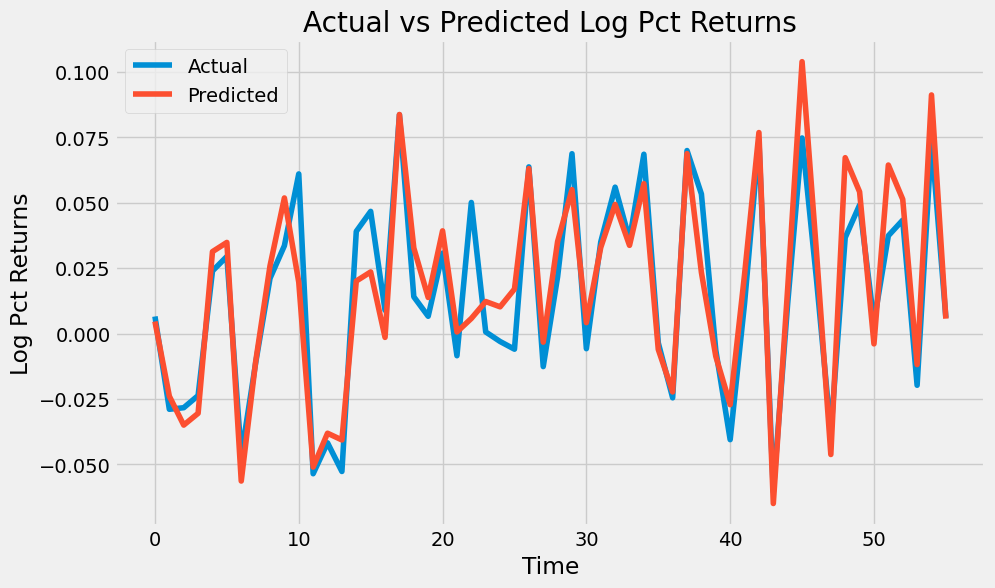

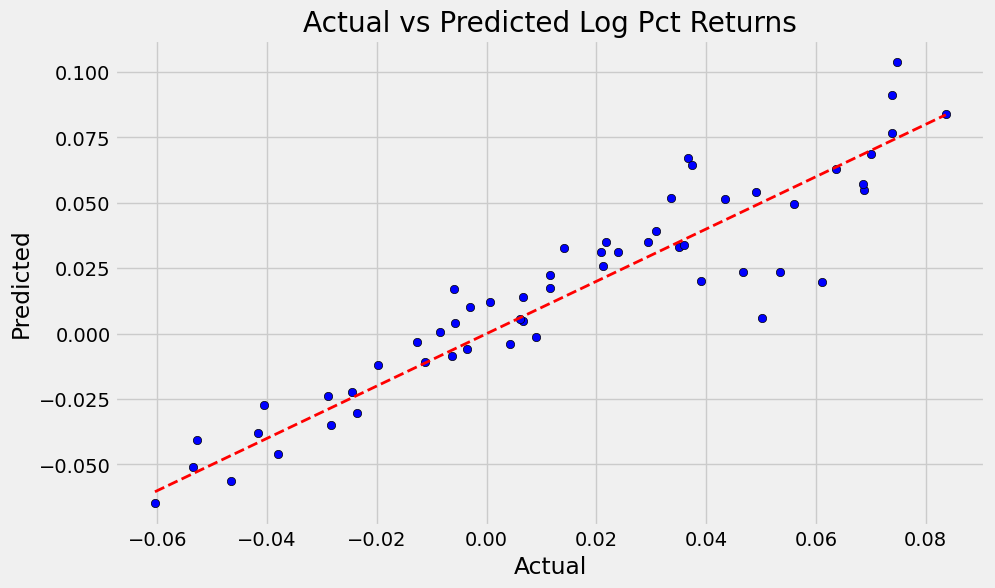

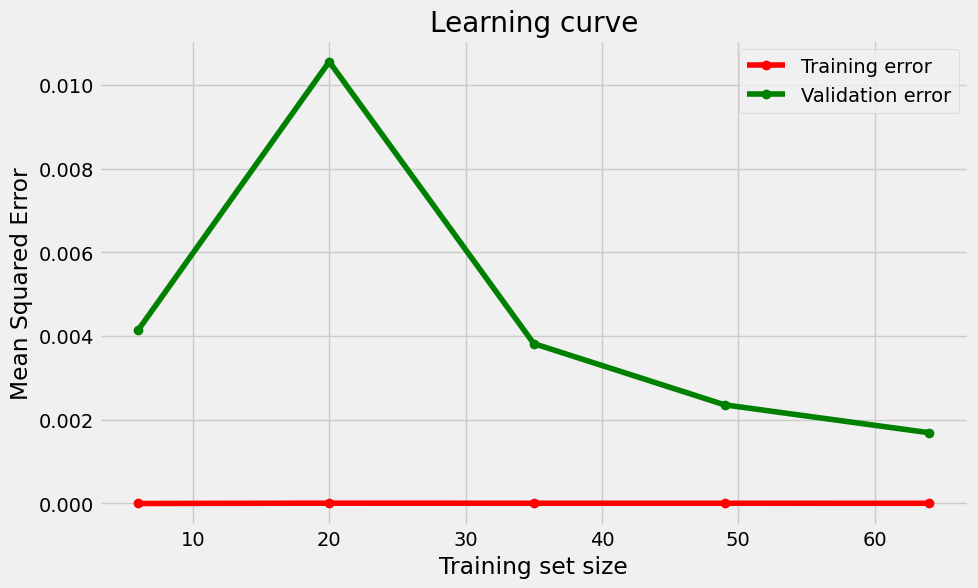

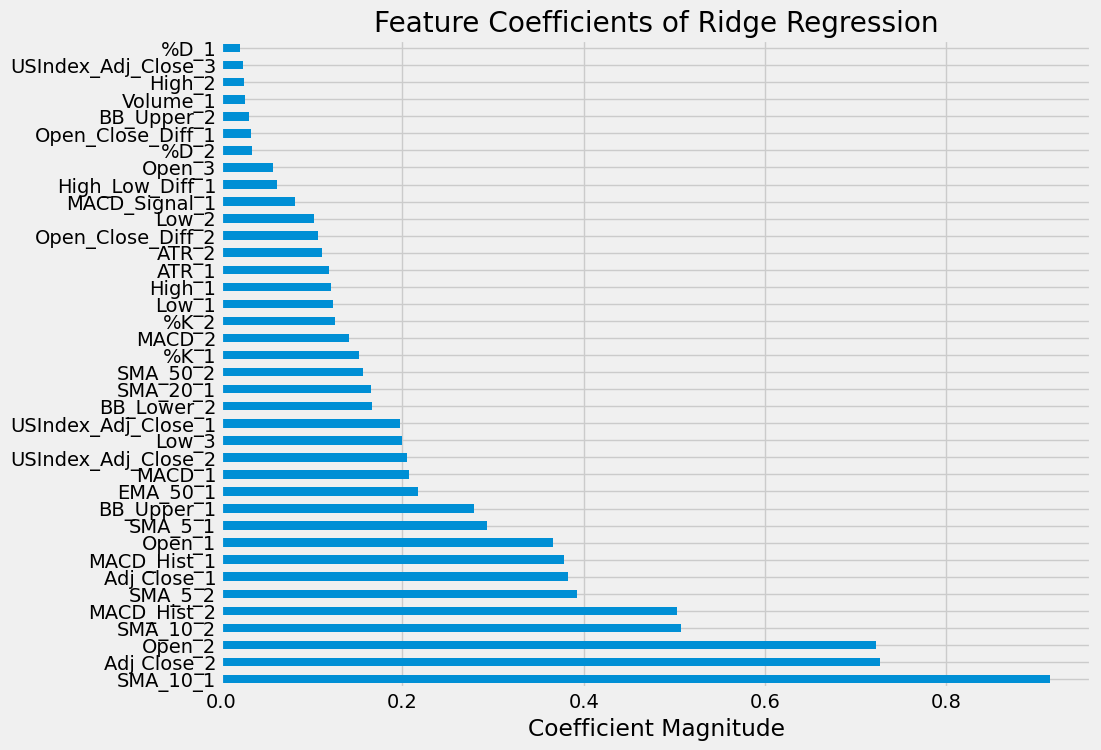

In [93]:
# Ridge Regression
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'USIndex_Adj_Close_1',
             'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','USIndex_Adj_Close_2',
             'Open_3',  'Low_3',
             'USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1',  '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_50_2',
             'MACD_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2'
            ]
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define the range of alpha values to test
alpha_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Create a parameter grid
param_grid = {'alpha': alpha_values}

# Initialize Ridge regression model
model = Ridge()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []
perm_imp_scores = []

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model from GridSearchCV
    model = grid_search.best_estimator_

    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_imp = result.importances_mean
    perm_imp_scores.append(perm_imp)
    
    # Predict on the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Calculate mean permutation importance across all folds
mean_perm_imp = np.mean(perm_imp_scores, axis=0)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize permutation importance
feature_names = X.columns
sorted_idx = mean_perm_imp.argsort()

plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], mean_perm_imp[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()

# Get coefficients of the model
coefficients = model.coef_

# Match coefficients with feature names
coef_importance = pd.Series(coefficients, index=X.columns)

# Sort coefficients by absolute value
sorted_coef_importance = coef_importance.abs().sort_values(ascending=False)

# Visualize coefficients
plt.figure(figsize=(10, 8))
sorted_coef_importance.plot(kind='barh')
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Coefficients of Ridge Regression')
plt.show()
